# Experiments: Standard Scenario

## Utils: 

- Density based clustering
- Nearest-cluster centroids

In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
from scipy.stats import trim_mean


def find_avg_centroid(x):
    return np.mean(x, axis=0)

def trimmed_mean_centroid(x, proportion_to_cut=0.1):
    """
    Compute the trimmed mean centroid of an array of points.
    """
    return trim_mean(x, proportiontocut=proportion_to_cut, axis=0)

def find_better_centroid(x):
    return trimmed_mean_centroid(x)

def find_nearest_centroids(x, y):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
        
    clf = NearestCentroid(metric='manhattan')
    clf = clf.fit(x, y)
    centroids = clf.centroids_
    return centroids

def find_knn(x, centroids, n_neighbors=10):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()

    knn_search = NearestNeighbors(n_neighbors=n_neighbors,
                            metric='manhattan', 
                            algorithm='auto', #'ball_tree'
                            n_jobs=-1)  
    knn_search.fit(x)

    indexes = knn_search.kneighbors(centroids, return_distance=False)
    return x[indexes][0]

        
def get_clusters(x):
    db = DBSCAN(eps=0.3, min_samples=10, leaf_size=30, 
                n_jobs=-1, metric='cosine').fit(x)

    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    # core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_ == 0:
        return x, labels, n_clusters_
    # Remove outliers to avoid affecting the centroids
    x = x[np.where(labels != -1)]
    labels = labels[np.where(labels != -1)]
    
    return x, labels, n_clusters_


def get_nearest_embedding_centroids(x, n_neighbors=10):
    
    #1. Get the CLIP embeddings
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
    
    #2. Cluster the embeddings
    x, labels, n_clusters = get_clusters(x)

    #3. Find centroids of embeddings
    if n_clusters < 2:
        # centroids = find_avg_centroid(x)
        centroids = find_better_centroid(x)
        centroids = centroids.reshape(1, -1)
    else:
        centroids = find_nearest_centroids(x, labels)

    # If some infinite/nan values appear
    centroids = np.nan_to_num(centroids)
    #4. Find knn of centroids        
    x_nearest_centroids = find_knn(x, centroids, n_neighbors)
    x_chosen = np.vstack([centroids, x_nearest_centroids])

    print(f"# nearest centroids ({round((x_chosen.shape[0]/x.shape[0])*100, 2)}%):", x_chosen.shape)
    print()

    return x_chosen


### Semantic embedding

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
embeder, preprocess = clip.load("ViT-B/32", device=device)

Device: cpu

In [4]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from functools import lru_cache

@lru_cache(maxsize=None)
def get_embeddings(dataset):
    
    all_features = []
    all_labels = []
    all_tasks = []
    
    with torch.no_grad():
        for images, labels, tasks in tqdm(DataLoader(dataset, batch_size=100, num_workers=8)):
            features = embeder.encode_image(images.to(device))
            # features = embeder_resnet(images.to(device)).squeeze()

            all_features.append(features)
            all_labels.append(labels)
            all_tasks.append(tasks)

    return (torch.cat(all_features).cpu().numpy(), 
            torch.cat(all_labels).cpu().numpy(), torch.cat(all_tasks).cpu().numpy())


## Obtain the SODA10M dataset

In [5]:
import sys
sys.path.append('./CLAD/')
import clad
import torchvision


root = "./data"
original_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.3252, 0.3283, 0.3407), (0.0265, 0.0241, 0.0252))

])

# all_train_sets = clad.get_cladc_train(root, transform=lambda x: x)
all_train_sets = clad.get_cladc_train(root, transform=original_transform)
# val_sets = clad.get_cladc_val(root, transform=torchvision.transforms.ToTensor())
print(len(all_train_sets))
print([len(ts) for ts in all_train_sets])

[INFO] No Detectron installation found, continuing without.


6

[5157, 1154, 6742, 2560, 4517, 2119]

In [6]:
# method_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.ToPILImage()
# ])
method_transform = torchvision.transforms.Compose([
    preprocess
])
all_train_sets_method = clad.get_cladc_train(root, transform=method_transform)
print(len(all_train_sets_method))
print([len(ts) for ts in all_train_sets_method])

6

[5157, 1154, 6742, 2560, 4517, 2119]

### Train/Test split

In [7]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
# test_size = 0.2

# Split each dataset in the train_sets list into training and testing sets
train_sets = []
test_sets = []
for dataset in all_train_sets:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets.append(train_dataset)
    test_sets.append(test_dataset)

print("Original data")
print('Training lenghts: ', [len(ts) for ts in train_sets])
print('Testing lenghts: ', [len(ts) for ts in test_sets])

train_sets_method = []
test_sets_method = []
for dataset in all_train_sets_method:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])

Original data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

Method data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

In [8]:
%%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark



# Original benchmark with tasks
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Original benchmark without tasks
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(0, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(0, len(test_s))))

benchmark_no_task= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Method benchmark
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark_method= dataset_benchmark(
    training_datasets,
    testing_datasets
)

CPU times: user 615 ms, sys: 124 ms, total: 740 ms
Wall time: 777 ms


## Test a simple Task classifier and save in cache

In [ ]:
train_stream = benchmark_method.train_stream
test_stream = benchmark_method.test_stream

all_x_train_emb = list()
all_y_train = list()
all_t_train = list()

all_x_test_emb = list()
all_y_test = list()
all_t_test = list()


for task, experience in enumerate(train_stream):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(train_stream[task].dataset)

    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    x_test_emb, y_test, t_test = get_embeddings(test_stream[task].dataset)
    print("x_test shape: ", x_test_emb.shape)
    all_x_test_emb.append(x_test_emb)
    all_y_test.append(y_test)
    all_t_test.append(t_test)

Getting embeddings

100%|██████████| 42/42 [02:01<00:00,  2.89s/it]


x_train shape: 
(4125, 512)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
%%time
print("Training data knn")
x_train_knn_total = [get_nearest_embedding_centroids(task, n_neighbors=10) for task in all_x_train_emb]
print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train))]
x_train_knn_total = np.vstack(x_train_knn_total)
y_train_knn_total = np.hstack(y_train_knn_total)
print(x_train_knn_total.shape)
print("y_train_knn_total ", y_train_knn_total.shape)

print()
print("Testing")
print("x_test shape: ", [e.shape[0] for e in all_x_test_emb])
x_test_total = np.vstack(all_x_test_emb)
y_test_total = np.hstack(all_t_test)
print("x_test_total ", x_test_total.shape)
print("y_test_total ", y_test_total.shape)

In [ ]:
# from sklearn.neighbors import NearestCentroid
# from sklearn.preprocessing import StandardScaler

# def scale_data(x_train, x_test):
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train_scaled = scaler.transform(x_train)
#     x_test_scaled = scaler.transform(x_test)
#     return x_train_scaled, x_test_scaled

# x_train_scaled, x_test_scaled = scale_data(x_train_knn_total, x_test_total)

clf = NearestCentroid(metric='manhattan')
clf = clf.fit(x_train_knn_total, y_train_knn_total)
print(f"score training knn: {clf.score(x_train_knn_total, y_train_knn_total)}")
print(f"score testing: {clf.score(x_test_total, y_test_total)}")
# clf = clf.fit(x_train_scaled, y_train_knn_total)
# print(f"score training knn: {clf.score(x_train_scaled, y_train_knn_total)}")
# print(f"score testing: {clf.score(x_test_scaled, y_test_total)}")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(clf, x_val_total, y_val_total)  
predictions = clf.predict(x_test_total)
cm = confusion_matrix(y_test_total, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)

disp.plot()
plt.title(f"SODA(n_tasks=6) | Accuracy: {round(clf.score(x_test_total, y_test_total), 2)}%")
plt.show();

## Utils for the incremental task classifier

In [ ]:
import statistics as st


def run_method(benchmark_method, test_stream, new_training, new_testing, task=0):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(benchmark_method.train_stream[task].dataset)


    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    # Training incremental domain classifier
    print("Training Domain Classifier model")
    x_train_knn_total = [get_nearest_embedding_centroids(_x_train, n_neighbors=10) for _x_train in all_x_train_emb]
    print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
    y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train))]
    x_train_knn_total = np.vstack(x_train_knn_total)
    y_train_knn_total = np.hstack(y_train_knn_total)
    print("x_train_knn_total shape: ", x_train_knn_total.shape)
    print("y_train_knn_total shape", y_train_knn_total.shape)
    if len(set(y_train_knn_total)) > 1:
        clf = NearestCentroid(metric='manhattan')
        clf = clf.fit(x_train_knn_total, y_train_knn_total)
        
    print("y_train_knn_total", np.random.choice(y_train_knn_total, 10))
    
    # Testing
    # print("Testing")
    x_test_emb, y_test, t_test = get_embeddings(benchmark_method.test_stream[task].dataset)

    if len(set(y_train_knn_total)) > 1:
        print("Using the classifier:")
        task_labels = clf.predict(x_test_emb)
        print("Count predictions: ", dict(zip(*np.unique(task_labels, return_counts=True))))
        print("Using the mode to get the most voting prediction:")
        mode = st.mode(task_labels)
        task_labels = np.repeat(mode, len(task_labels))
    else:
        print("Fist scenario: Task ID=", task)
        task_labels = np.repeat(task, len(benchmark_method.test_stream[task].dataset))
    print(f"Predictions: {np.random.choice(task_labels, 10)}")
    print(f"Predictions shape: {task_labels.shape}")

    new_training.append(benchmark_method.train_stream[task].dataset)
    new_testing.append(make_classification_dataset(test_stream[task].dataset, task_labels=task_labels))

    benchmark_custom = dataset_benchmark(
        new_training,
        new_testing
    )

    return benchmark_custom

## Prepare the strategies to run

In [ ]:
def get_strategy(strategy_name, model, optimizer, criterion, eval_plugin, n_epochs=6):
    strategies = {
        'EWC': EWC( #Regularization-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            ewc_lambda=0.2,
        ),
        'Replay': Replay( #Rehearsal-based method
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_mb_size=200,
            train_epochs=n_epochs,
            eval_mb_size=200,
            device=device,
            evaluator=eval_plugin,
            mem_size=200,
        ),
        'LwF': LwF( #Architecture-based method
            model,
            optimizer,
            criterion,
            alpha=0.5,
            temperature=0.2,
            train_epochs=n_epochs,
            device=device,
            train_mb_size=200,
            eval_mb_size=200,
            evaluator=eval_plugin,
        ),
    }

    return strategies[strategy_name]

## Prepare and run the experiments

In [ ]:
root_exp_name = 'Task_boundary'
# root_exp_name = 'Agnostic_with_repetition'
# sequence = [0, 1, 2, 1, 3, 3, 4, 5]
# sequence = [0, 1, 2, 3, 4, 5]
n_epochs = 6
random_seeds = [7]
# random_seeds = [51, 12, 42, 7]
num_experiments = len(random_seeds)
print(f"n_exps = {num_experiments}")
print(f"Setup = {root_exp_name}")
print(f"Epochs = {n_epochs}")

In [ ]:
import torch
import random
import gc
from torch.nn import CrossEntropyLoss
import copy
import statistics as st
from torch.optim import Adam
from rich import print
from avalanche.models import as_multitask
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST
from avalanche.models import MTSimpleMLP, MTSimpleCNN, SimpleCNN, SimpleMLP
# from avalanche.training.supervised import EWC, Naive, LFL
from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
)
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
# from avalanche.training import Naive
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, RotatedMNIST, SplitCIFAR10, SplitCIFAR100
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark
from avalanche.training.utils import adapt_classification_layer

from datetime import datetime
from avalanche.evaluation.metrics.images_samples import images_samples_metrics
from avalanche.evaluation.metrics.labels_repartition import (
    labels_repartition_metrics,
)
from avalanche.evaluation.metrics.mean_scores import mean_scores_metrics
from torch.nn import Linear
from avalanche.training.supervised import Replay, GEM, LwF, EWC

# choose some metrics and evaluation method
# loggers = []

# loggers.append(InteractiveLogger())

# eval_plugin = EvaluationPlugin(
#     accuracy_metrics(
#         minibatch=False, epoch=True, experience=True
#     ),

#     forgetting_metrics(experience=True),
#     loggers=loggers,
# )
    
# num_experiments = 2
# # num_experiments = 3
# random_seeds = [42, 123, 456]

# results_list = []
for exp in range(num_experiments):
    
    train_stream = benchmark.train_stream
    test_stream = benchmark.test_stream

    print(f"Length training: {len(benchmark.train_stream[0].dataset)}")
    print(f"Length testing: {len(benchmark.test_stream[0].dataset)}")

    print("-"*50)


    n_workers = 8

    seed = random_seeds[exp]
    random.seed(seed)
    torch.manual_seed(seed)
    print(f"Setup = {root_exp_name}")
    print(f"Experiment: {exp+1} / {num_experiments}")
    print(f"Seed = {seed}")
    # torch.cuda.manual_seed(seed)
    all_strategies = ['EWC', 'Replay', 'LwF']
    
    for strategy_name in all_strategies:
        loggers = []

        loggers.append(InteractiveLogger())

        eval_plugin = EvaluationPlugin(
            accuracy_metrics(
                minibatch=False, epoch=False, experience=True
            ),

            # forgetting_metrics(experience=True),
            loggers=loggers,
        )

        model = torchvision.models.resnet18(weights=True)
        # model.fc = Linear(model.fc.in_features, 7, bias=True)
        model.fc = Linear(model.fc.in_features, 7, bias=True)
        mt_model = as_multitask(model, 'fc')

        optimizer = Adam(mt_model.parameters(), lr=0.01)
        criterion = CrossEntropyLoss()
    
        strategy = get_strategy(strategy_name, mt_model, optimizer, criterion, eval_plugin, n_epochs)
        print(f"Running strategy: {strategy}, experiment: {exp}")
        results = {key: [] for key in ['ground_truth', 'TADIL', 'normal']}
        
        all_x_train_emb = list()
        all_y_train = list()
        all_t_train = list()

        all_x_test_emb = list()
        all_y_test = list()
        all_t_test = list()        
        new_training = list()
        new_testing = list()

        for task, experience in enumerate(train_stream):
            curr_experience = experience.current_experience
            print("Current experience: ", curr_experience)    
            print("Experience task ID ", experience.task_label)
            print('Experience shape:', len(experience.dataset))


            # Training
            print("Training multi-head model")
            strategy.train(experience, num_workers=n_workers)
            print('Training multi-head model completed')

            # Run the method
            benchmark_custom = run_method(benchmark_method, test_stream, new_training, new_testing, task=task)

            # Testing
            print("Evaluation benchmark: Ground Truth")
            results['ground_truth'].append(strategy.eval(benchmark.test_stream[:task+1], num_workers=n_workers))

            print("Evaluation benchmark: TADIL")
            results['TADIL'].append(strategy.eval(benchmark_custom.test_stream, num_workers=n_workers))

            print("Evaluation benchmark: Normal")
            results['normal'].append(strategy.eval(benchmark_no_task.test_stream[:task+1], num_workers=n_workers))

            print("-"*40)
            print()

        
        benchmark_custom = None
            
        with open(f'{root_exp_name}_{strategy_name}_{seed}.pickle', 'wb') as handle:
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Saved results for {root_exp_name}_{strategy_name}, seed: {seed}")


        print("-"*40)
        print()
    print("-"*80)

## Plot the comparison using model's accuracies

In [21]:
strategy_name = "EWC"
n_exp = 0
# strategy_name = "LwF"
with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [23]:
results.keys()

dict_keys(['ground_truth', 'TADIL', 'normal'])

In [98]:
# import matplotlib.pyplot as plt

# # Extract the eval_phase values
# def get_eval_phase_values(data, keyword):
#     eval_values = []
#     for exp in data:
#         eval_values.append({k: v for k, v in exp.items() if ('eval_phase/test_stream' in k) and (keyword in k)})
#     return eval_values

# results_clean = {k:get_eval_phase_values(results[k], "Top1_Acc_Exp") for k in results.keys()}

### Plot the numbers

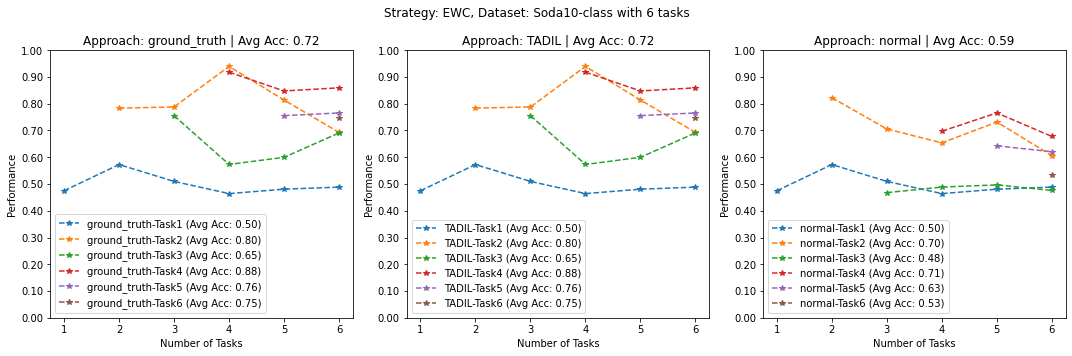

In [18]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

strategy_name = "EWC"
n_exp = 1
# strategy_name = "LwF"
with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
    results = pickle.load(handle)


metric_root_name = "Top1_Acc_Exp/eval_phase/test_stream"

# Create a dictionary to store the scores for each method
method_scores = {
    'ground_truth': [],
    'TADIL': [],
    'normal': [],
}

for domain in range(len(results['ground_truth'])):
    scores_task = []
    scores_method = []
    scores_third_method = [] # Initialize an empty list for the scores of the third method
    iters_ = []
    for index, r in enumerate(results['ground_truth']):
        try:
            score_task = r[f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_method = results['TADIL'][index][f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
            score_third_method = results['normal'][index][f"{metric_root_name}/Task00{0}/Exp00{domain}"] # Get the score of the third method
            if score_task != 0:
                scores_task.append(score_task)
                scores_method.append(score_method)
                scores_third_method.append(score_third_method) # Append the score of the third method to the list
                iters_.append(index + 1)
        except:
            pass
    method_scores['ground_truth'].append((iters_, scores_task))
    method_scores['TADIL'].append((iters_, scores_method))
    method_scores['normal'].append((iters_, scores_third_method)) # Append the scores of the third method to the dictionary


max_iter = max([max(scores, key=lambda s: s[0][-1])[0][-1] for scores in method_scores.values()])  # Get the maximum iteration index for all methods

fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # Create 3 subplots arranged horizontally
plt.suptitle(f"Strategy: {strategy_name}, Dataset: Soda10-class with {len(results['ground_truth'])} tasks")

for i, (method_name, method_scores_list) in enumerate(method_scores.items()):
    
    avg_list = list()
    for j, (x, y) in enumerate(method_scores_list):
        average_accuracy = np.mean(y)  # Calculate the average accuracy
        avg_list.append(average_accuracy)
        axs[i].plot(x, y, '*--', label=f'{method_name}-Task{j+1} (Avg Acc: {average_accuracy:.2f})')  # Include the average accuracy in the label
        axs[i].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i].set_yticklabels(["{:.2f}".format(val) for val in np.arange(0, 1.1, 0.1)])
        axs[i].legend()
        
    axs[i].set_title(f"Approach: {method_name} | Avg Acc: {round(np.mean(avg_list), 2)}")
    
    axs[i].set_xlabel("Number of Tasks")
    axs[i].set_ylabel("Performance")
    axs[i].set_xticks(np.arange(1, max_iter+1))

plt.tight_layout() 
plt.savefig(f'{strategy_name}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


## Table

In [112]:
import pandas as pd

df_tables = dict()
strategy_names = ['EWC', 'LwF', 'Replay']
for strategy_name in strategy_names:
    # strategy_name = "LwF"
    n_exp = 1
    # strategy_name = "LwF"
    with open(f'{strategy_name}_{n_exp}.pickle', 'rb') as handle:
        results = pickle.load(handle)

    method_scores = {
        'ground_truth': [],
        'TADIL': [],
        'normal': [],
    }

    for domain in range(len(results['ground_truth'])):
        scores_task = []
        scores_method = []
        scores_third_method = []
        iters_ = []
        for index, r in enumerate(results['ground_truth']):
            try:
                score_task = r[f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
                score_method = results['TADIL'][index][f"{metric_root_name}/Task00{domain}/Exp00{domain}"]
                score_third_method = results['normal'][index][f"{metric_root_name}/Task00{0}/Exp00{domain}"] # Get the score of the third method
                if score_task != 0:
                    scores_task.append(score_task)
                    scores_method.append(score_method)
                    scores_third_method.append(score_third_method) # Append the score of the third method to the list
                    iters_.append(index + 1)
            except:
                pass
        method_scores['ground_truth'].append((iters_, scores_task))
        method_scores['TADIL'].append((iters_, scores_method))
        method_scores['normal'].append((iters_, scores_third_method)) # Append the scores of the third method to the dictionary


    max_iter = max([max(scores, key=lambda s: s[0][-1])[0][-1] for scores in method_scores.values()])  # Get the maximum iteration index for all methods

    avg_acc_df = pd.DataFrame(columns=method_scores.keys(), index=range(1, len(method_scores_list) + 1))


    for method_name, method_scores_list in method_scores.items():
        for j, (x, y) in enumerate(method_scores_list):
            average_accuracy = np.mean(y)
            std_dev = np.std(y)
            avg_acc_df.at[j+1, method_name] = f"{average_accuracy:.2f} ({round(std_dev, 2)})"

    # Display the DataFrame
    avg_acc_df.index = [f"Task {i+1}" for i in range(len(method_scores_list))]
    avg_acc_df = avg_acc_df.reset_index()
    avg_acc_df = avg_acc_df.rename(columns={'index': 'Task ID', 'ground_truth': 'Ground Truth', 'normal': 'Normal'})
    print(strategy_name)
    print(avg_acc_df)
    df_tables[strategy_name] = avg_acc_df

EWC

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.59 (0.04)  0.59 (0.04)  0.59 (0.04)
1  Task 2  0.82 (0.08)  0.82 (0.08)  0.69 (0.03)
2  Task 3  0.69 (0.07)  0.69 (0.07)  0.56 (0.04)
3  Task 4   0.89 (0.0)   0.89 (0.0)  0.74 (0.03)
4  Task 5  0.74 (0.05)  0.74 (0.05)  0.68 (0.03)
5  Task 6   0.73 (0.0)   0.73 (0.0)   0.71 (0.0)

LwF

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.62 (0.05)  0.62 (0.05)  0.62 (0.05)
1  Task 2  0.86 (0.01)  0.86 (0.01)  0.86 (0.02)
2  Task 3  0.70 (0.02)  0.70 (0.02)  0.56 (0.03)
3  Task 4  0.87 (0.01)  0.87 (0.01)  0.85 (0.03)
4  Task 5   0.75 (0.0)   0.75 (0.0)  0.74 (0.01)
5  Task 6   0.65 (0.0)   0.65 (0.0)   0.58 (0.0)

Replay

Task ID Ground Truth        TADIL       Normal
0  Task 1  0.77 (0.03)  0.77 (0.03)  0.77 (0.03)
1  Task 2  0.93 (0.02)  0.93 (0.02)  0.88 (0.02)
2  Task 3  0.81 (0.01)  0.81 (0.01)   0.75 (0.0)
3  Task 4  0.90 (0.01)  0.90 (0.01)  0.83 (0.02)
4  Task 5  0.82 (0.01)  0.82 (0.01)  0.76 (0.01)
5  Task 6   0.80 (0.0)   0.80 (0.0)   0.77 (0.0)

## Table to latex

In [113]:
import pandas as pd


final_df = pd.DataFrame()
for key, df in df_tables.items():

    df = df.reset_index(drop=True)
    df.insert(0, "Strategy", key)
    final_df = final_df.append(df, ignore_index=True)
    
unique_strategies = final_df["Strategy"].unique()
for i, strategy in enumerate(unique_strategies):
    final_df.loc[(final_df["Strategy"] == strategy) & (final_df.index != i * len(df)), "Strategy"] = ""


latex_table = final_df.to_latex(index=False, float_format="%.2f", bold_rows=True, column_format="|l|l|c|c|c|", multicolumn_format="c")


# Add grid lines to the table
latex_table = latex_table.replace('\\toprule', '\\hline')
latex_table = latex_table.replace('\\midrule', '\\hline')
latex_table = latex_table.replace('\\bottomrule', '\\hline')

# Print the LaTeX table
print(latex_table)


<ipython-input-113-0ca883fb85e9>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-113-0ca883fb85e9>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-113-0ca883fb85e9>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df, ignore_index=True)
<ipython-input-113-0ca883fb85e9>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functional

\begin{tabular}{|l|l|c|c|c|}
\hline
Strategy & Task ID & Ground Truth &       TADIL &      Normal \\
\hline
     EWC &  Task 1 &  0.59 (0.04) & 0.59 (0.04) & 0.59 (0.04) \\
         &  Task 2 &  0.82 (0.08) & 0.82 (0.08) & 0.69 (0.03) \\
         &  Task 3 &  0.69 (0.07) & 0.69 (0.07) & 0.56 (0.04) \\
         &  Task 4 &   0.89 (0.0) &  0.89 (0.0) & 0.74 (0.03) \\
         &  Task 5 &  0.74 (0.05) & 0.74 (0.05) & 0.68 (0.03) \\
         &  Task 6 &   0.73 (0.0) &  0.73 (0.0) &  0.71 (0.0) \\
     LwF &  Task 1 &  0.62 (0.05) & 0.62 (0.05) & 0.62 (0.05) \\
         &  Task 2 &  0.86 (0.01) & 0.86 (0.01) & 0.86 (0.02) \\
         &  Task 3 &  0.70 (0.02) & 0.70 (0.02) & 0.56 (0.03) \\
         &  Task 4 &  0.87 (0.01) & 0.87 (0.01) & 0.85 (0.03) \\
         &  Task 5 &   0.75 (0.0) &  0.75 (0.0) & 0.74 (0.01) \\
         &  Task 6 &   0.65 (0.0) &  0.65 (0.0) &  0.58 (0.0) \\
  Replay &  Task 1 &  0.77 (0.03) & 0.77 (0.03) & 0.77 (0.03) \\
         &  Task 2 &  0.93 (0.02) & 0.93 (0.02) & 0.88 (0.02) \\
         &  Task 3 &  0.81 (0.01) & 0.81 (0.01) &  0.75 (0.0) \\
         &  Task 4 &  0.90 (0.01) & 0.90 (0.01) & 0.83 (0.02) \\
         &  Task 5 &  0.82 (0.01) & 0.82 (0.01) & 0.76 (0.01) \\
         &  Task 6 &   0.80 (0.0) &  0.80 (0.0) &  0.77 (0.0) \\
\hline
\end{tabular}